# Meter Reader with PaddleOCR
This notebook shows how to create a meter reader with OpenVINO Runtime. We use the pre-trained [PP-OCR](https://github.com/PaddlePaddle/PaddleOCR) to build up a inference task pipeline:

1. Config the screen area of the meter reader.
2. Config the layout information of the meter reader.
3. Pre-process the image based on the given information.
4. Perform OCR recognition.
5. Structure output information.

<img align='center' src= "https://user-images.githubusercontent.com/83450930/236680983-f23e8728-c7f9-4460-8794-44fac360a4ac.png" alt="drawing" width="1500"/>

In some cases, the screen area in the image is not in a fixed position. A detection model can be used to dynamically provide the screen area information. Please see [PaddleDetection](https://github.com/PaddlePaddle/PaddleDetection) for more details.

## Imports

In [1]:
import os
import cv2
import numpy as np
import sys
import math
import matplotlib.pyplot as plt
import tarfile
import copy

from openvino.runtime import Core

sys.path.append("../utils")
import notebook_utils as utils

## PaddleOCR with OpenVINO™

[PaddleOCR](https://github.com/PaddlePaddle/PaddleOCR) is an ultra-light OCR model trained with PaddlePaddle deep learning framework, which aims to create multilingual and practical OCR tools. 

The PaddleOCR pre-trained model used in the demo refers to the *"Chinese and English ultra-lightweight PP-OCR model (9.4M)"*. More open source pre-trained models can be downloaded at [PaddleOCR Github](https://github.com/PaddlePaddle/PaddleOCR) or [PaddleOCR Gitee](https://gitee.com/paddlepaddle/PaddleOCR).

A standard PaddleOCR includes two parts of deep learning models, text detection and text recognition. This notebook only needs the text recognition part. For running the model, we first initialize the runtime for inference, then, read the network architecture and model weights from the `.pdmodel` and `.pdiparams` files to load to CPU.

More details for running PaddleOCR with OpenVINO™ are shown in [405-paddle-ocr-webcam](../405-paddle-ocr-webcam/405-paddle-ocr-webcam.ipynb).

### Download the Model for Text **Recognition**

The pre-trained models used in the demo are downloaded and stored in the "model" folder.

In [2]:
MODEL_DIR = "model"
RECOGNITION_MODEL_LINK = "https://paddleocr.bj.bcebos.com/PP-OCRv3/chinese/ch_PP-OCRv3_rec_infer.tar"
RECOGNITION_FILE_NAME = RECOGNITION_MODEL_LINK.split("/")[-1]

# download file
os.makedirs(MODEL_DIR, exist_ok=True)
utils.download_file(RECOGNITION_MODEL_LINK, directory=MODEL_DIR, show_progress=True)
file = tarfile.open(f"model/{RECOGNITION_FILE_NAME}")
res = file.extractall("model")
if not res:
    print(f"Detection Model Extracted to \"./{MODEL_DIR}\".")
else:
    print("Error Extracting the Detection model. Please check the network.")

'model\ch_PP-OCRv3_rec_infer.tar' already exists.
Detection Model Extracted to "./model".


### Load the Model for Text **Recognition** with Dynamic Shape

Input to text recognition model refers to detected bounding boxes with different image sizes, for example, dynamic input shapes. Hence:

1. Input dimension with dynamic input shapes needs to be specified before loading text recognition model.
2. Dynamic shape is specified by assigning -1 to the input dimension or by setting the upper bound of the input dimension using, for example, `Dimension(1, 512)`.

>Note: Since the text recognition model is with dynamic input shape and current release of OpenVINO 2022.2 does not support dynamic shape on iGPU, you cannot directly switch device to iGPU for inference in this case. Otherwise, you may need to resize the input images to this model into a fixed size and then try running the inference on iGPU.

In [3]:
# Initialize OpenVINO Runtime for text recognition.
core = Core()

# Read the model and corresponding weights from a file.
rec_model_file_path = f"{MODEL_DIR}/ch_PP-OCRv3_rec_infer/inference.pdmodel"
rec_model = core.read_model(model=rec_model_file_path)

# Assign dynamic shapes to every input layer on the last dimension.
for input_layer in rec_model.inputs:
    input_shape = input_layer.partial_shape
    input_shape[3] = -1
    rec_model.reshape({input_layer: input_shape})

rec_compiled_model = core.compile_model(model=rec_model, device_name="CPU")

# Get input and output nodes.
rec_input_layer = rec_compiled_model.input(0)
rec_output_layer = rec_compiled_model.output(0)

## Configuration and Helper functions

To structure output, we should first config some parameters (for example, the coordinates of the corners of the screen).

Then, use the following helper functions for preprocessing and postprocessing frames:

1. Preprocessing the input image: use affine transformations to normalize skewed images.
2. Preprocessing for text recognition: resize and normalize detected box images to the same size (for example, `(3, 32, 320)` size for images with Chinese text) for easy batching in inference.
3. Postprocessing for structure output: fix some errors in recognition.

### Configuration

There are four information to config:
1. POINTS: the edge of meter's screen, which can be determined by four corners
2. DESIGN_SHAPE: the original shape of the screen
3. DESIGN_LAYOUT: the elements and their positions in the screen, which is in a standard DESIGN_SHAPE
4. RESULT_TEMP: a template of output, which is a dictory. The keys in the `dict` are output features.

In the example image below, there are 8 features to output.
1. Info_Probe: Probe information of power frequency field strength meter. "探头:---" means there is no information about Porbe.
2. Freq_Set: The work frequency, and the "实时值" is a const text to tell user that the preceding numbers are real-time.
3. Val_Total: The value measured. "无探头" means there is no information about Porbe, otherwise, there should be a float value.
4. Val_X: Value from x axis.
5. Val_Y: Value from y axis.
6. Val_Z: Value from z axis.
7. Unit
8. Field: One of Conventional, electric field, magnetic field. The chinese words "电场" means electric field.

<img align='center' src= "https://user-images.githubusercontent.com/83450930/236680146-5751e291-d509-4d71-a2cb-bfbf35609051.jpg" alt="drawing" width="200"/>

In [4]:
# The coordinates of the corners of the screen
POINTS = [[1121, 56],    # Left top
          [3242, 183],   # right top
          [3040, 1841],  # right bottom
          [1000, 1543]]   # left bottom

# The size of the screen
DESIGN_SHAPE = (1300, 1000)

# Output template
RESULT_TEMP = {"Info_Probe":"探头:---", 
               "Freq_Set":"", 
               "Val_Total":"无探头", 
               "Val_X":"", 
               "Val_Y":"", 
               "Val_Z":"", 
               "Unit":"A/m", 
               "Field":"常规"}

# features and the layout information
DESIGN_LAYOUT = {'Info_Probe':[14, 36, 410, 135],  # feature_name, xmin, ymin, xmax, ymax
                 'Freq_Set':[5, 290, 544, 406], 
                 'Val_Total':[52, 419, 1256, 741], 
                 'Val_X':[19, 774, 433, 882], 
                 'Val_Y':[433, 773, 874, 884], 
                 'Val_Z':[873, 773, 1276, 883], 
                 'Unit':[1064, 291, 1295, 403], 
                 'Field':[5, 913, 243, 998]}

### Preprocessing the input image

Use affine transformations to normalize skewed images

In [5]:
def pre_processing(img, point_list, target_shape):
    # affine transformations
    # point list is the coordinates of the corners of the screen
    # target shape is the design shape
    
    target_w, target_h = target_shape
    pts1 = np.float32(point_list)
    pts2 = np.float32([[0, 0],[target_w,0],[target_w, target_h],[0,target_h]])
    
    M = cv2.getPerspectiveTransform(pts1, pts2)
    img2 = cv2.warpPerspective(img, M, (target_w,target_h))
    return img2

### Preprocessing Image Functions for Text Recognition

In [6]:
# Preprocess for text recognition.
def resize_norm_img(img, max_wh_ratio):
    """
    Resize input image for text recognition

    Parameters:
        img: bounding box image from text detection 
        max_wh_ratio: value for the resizing for text recognition model
    """
    rec_image_shape = [3, 48, 320]
    imgC, imgH, imgW = rec_image_shape
    assert imgC == img.shape[2]
    character_type = "ch"
    if character_type == "ch":
        imgW = int((32 * max_wh_ratio))
    h, w = img.shape[:2]
    ratio = w / float(h)
    if math.ceil(imgH * ratio) > imgW:
        resized_w = imgW
    else:
        resized_w = int(math.ceil(imgH * ratio))
    resized_image = cv2.resize(img, (resized_w, imgH))
    resized_image = resized_image.astype('float32')
    resized_image = resized_image.transpose((2, 0, 1)) / 255
    resized_image -= 0.5
    resized_image /= 0.5
    padding_im = np.zeros((imgC, imgH, imgW), dtype=np.float32)
    padding_im[:, :, 0:resized_w] = resized_image
    return padding_im


def get_rotate_crop_image(img, points):
    '''
    img_height, img_width = img.shape[0:2]
    left = int(np.min(points[:, 0]))
    right = int(np.max(points[:, 0]))
    top = int(np.min(points[:, 1]))
    bottom = int(np.max(points[:, 1]))
    img_crop = img[top:bottom, left:right, :].copy()
    points[:, 0] = points[:, 0] - left
    points[:, 1] = points[:, 1] - top
    '''
    assert len(points) == 4, "shape of points must be 4*2"
    img_crop_width = int(
        max(
            np.linalg.norm(points[0] - points[1]),
            np.linalg.norm(points[2] - points[3])))
    img_crop_height = int(
        max(
            np.linalg.norm(points[0] - points[3]),
            np.linalg.norm(points[1] - points[2])))
    pts_std = np.float32([[0, 0], [img_crop_width, 0],
                          [img_crop_width, img_crop_height],
                          [0, img_crop_height]])
    M = cv2.getPerspectiveTransform(points, pts_std)
    dst_img = cv2.warpPerspective(
        img,
        M, (img_crop_width, img_crop_height),
        borderMode=cv2.BORDER_REPLICATE,
        flags=cv2.INTER_CUBIC)
    dst_img_height, dst_img_width = dst_img.shape[0:2]
    if dst_img_height * 1.0 / dst_img_width >= 1.5:
        dst_img = np.rot90(dst_img)
    return dst_img


def prep_for_rec(dt_boxes, frame):
    """
    Preprocessing of the detected bounding boxes for text recognition

    Parameters:
        dt_boxes: detected bounding boxes from text detection 
        frame: original input frame 
    """
    ori_im = frame.copy()
    img_crop_list = [] 
    for bno in range(len(dt_boxes)):
        tmp_box = copy.deepcopy(dt_boxes[bno])
        img_crop = get_rotate_crop_image(ori_im, tmp_box)
        img_crop_list.append(img_crop)
        
    img_num = len(img_crop_list)
    # Calculate the aspect ratio of all text bars.
    width_list = []
    for img in img_crop_list:
        width_list.append(img.shape[1] / float(img.shape[0]))
    
    # Sorting can speed up the recognition process.
    indices = np.argsort(np.array(width_list))
    return img_crop_list, img_num, indices


def batch_text_box(img_crop_list, img_num, indices, beg_img_no, batch_num):
    """
    Batch for text recognition

    Parameters:
        img_crop_list: processed detected bounding box images 
        img_num: number of bounding boxes from text detection
        indices: sorting for bounding boxes to speed up text recognition
        beg_img_no: the beginning number of bounding boxes for each batch of text recognition inference
        batch_num: number of images for each batch
    """
    norm_img_batch = []
    max_wh_ratio = 0
    end_img_no = min(img_num, beg_img_no + batch_num)
    for ino in range(beg_img_no, end_img_no):
        h, w = img_crop_list[indices[ino]].shape[0:2]
        wh_ratio = w * 1.0 / h
        max_wh_ratio = max(max_wh_ratio, wh_ratio)
    for ino in range(beg_img_no, end_img_no):
        norm_img = resize_norm_img(img_crop_list[indices[ino]], max_wh_ratio)
        norm_img = norm_img[np.newaxis, :]
        norm_img_batch.append(norm_img)

    norm_img_batch = np.concatenate(norm_img_batch)
    norm_img_batch = norm_img_batch.copy()
    return norm_img_batch

### Postprocessing Image Functions for Text Recognition

The results of text recognition are text-index, we should convert is to the characters. The following codes construct a decoder for the conversion.

In [7]:
class RecLabelDecode(object):
    """ Convert between text-label and text-index """

    def __init__(self,
                 character_dict_path=None,
                 character_type='ch',
                 use_space_char=False):
        support_character_type = [
            'ch', 'en', 'EN_symbol', 'french', 'german', 'japan', 'korean',
            'it', 'xi', 'pu', 'ru', 'ar', 'ta', 'ug', 'fa', 'ur', 'rs', 'oc',
            'rsc', 'bg', 'uk', 'be', 'te', 'ka', 'chinese_cht', 'hi', 'mr',
            'ne', 'EN', 'latin', 'arabic', 'cyrillic', 'devanagari'
        ]
        assert character_type in support_character_type, "Only {} are supported now but get {}".format(
            support_character_type, character_type)

        self.beg_str = "sos"
        self.end_str = "eos"

        if character_type == "en":
            self.character_str = "0123456789abcdefghijklmnopqrstuvwxyz"
            dict_character = list(self.character_str)
        elif character_type == "EN_symbol":
            # same with ASTER setting (use 94 char).
            self.character_str = string.printable[:-6]
            dict_character = list(self.character_str)
        elif character_type in support_character_type:
            self.character_str = []
            assert character_dict_path is not None, "character_dict_path should not be None when character_type is {}".format(
                character_type)
            with open(character_dict_path, "rb") as fin:
                lines = fin.readlines()
                for line in lines:
                    line = line.decode('utf-8').strip("\n").strip("\r\n")
                    self.character_str.append(line)
            if use_space_char:
                self.character_str.append(" ")
            dict_character = list(self.character_str)
        else:
            raise NotImplementedError
        self.character_type = character_type
        dict_character = self.add_special_char(dict_character)
        self.dict = {}
        for i, char in enumerate(dict_character):
            self.dict[char] = i
        self.character = dict_character

        
    def __call__(self, preds, label=None, *args, **kwargs):
        preds_idx = preds.argmax(axis=2)
        preds_prob = preds.max(axis=2)
        text = self.decode(preds_idx, preds_prob, is_remove_duplicate=True)
        if label is None:
            return text
        label = self.decode(label)
        return text, label

    
    def add_special_char(self, dict_character):
        dict_character = ['blank'] + dict_character
        return dict_character

    
    def decode(self, text_index, text_prob=None, is_remove_duplicate=False):
        """ convert text-index into text-label. """
        result_list = []
        ignored_tokens = self.get_ignored_tokens()
        batch_size = len(text_index)
        for batch_idx in range(batch_size):
            char_list = []
            conf_list = []
            for idx in range(len(text_index[batch_idx])):
                if text_index[batch_idx][idx] in ignored_tokens:
                    continue
                if is_remove_duplicate:
                    # only for predict
                    if idx > 0 and text_index[batch_idx][idx - 1] == text_index[
                            batch_idx][idx]:
                        continue
                char_list.append(self.character[int(text_index[batch_idx][
                    idx])])
                if text_prob is not None:
                    conf_list.append(text_prob[batch_idx][idx])
                else:
                    conf_list.append(1)
            text = ''.join(char_list)
            result_list.append((text, np.mean(conf_list)))
        return result_list

    
    def get_ignored_tokens(self):
        return [0]  # for ctc blank


# Since the recognition results contain chinese words, we should use 'ch' as character_type
text_decoder = RecLabelDecode(character_dict_path="../data/text/ppocr_keys_v1.txt",
                              character_type='ch',  
                              use_space_char=True)

### Postprocessing

Post-processing is a very personal step. The image to be recognized may appear blurry, halo, etc., and there may be some errors in the recognition result, which can be corrected through post-processing.

The following code fixes some issues that may exist in the example situation.

In [8]:
def post_processing(results):
    # `LF` can be recognized correctly, but the other may be misidentified
    if 'LF' in results['Info_Probe']: 
        results['Info_Probe'] = "探头:LF-01"
    
    # the target infor is `Frequence`, do not need the suffix `实时值`
    # we will simply delete the words `实时值`
    results['Freq_Set'] = results['Freq_Set'].split('实时值')[0]
    
    # the recognition model may confuse `Z` and `2`
    # we can replace the `H2` to `Hz`
    results['Freq_Set'] = results['Freq_Set'].replace('H2','Hz')
    
    # the target infor is values, do not need the prefix
    results['Val_X'] = results['Val_X'].replace("X","").replace(":","") 
    results['Val_Y'] = results['Val_Y'].replace("Y","").replace(":","") 
    results['Val_Z'] = results['Val_Z'].replace("Z","").replace(":","") 
    
    # μ is easy to be recognized as u, and '/' is aesy to be ignored
    if 'T' in results['Unit']: 
        results['Unit'] = "μT"
    elif 'kV' in results['Unit'] or 'kv' in results['Unit']:
        results['Unit'] = "kV/m"
    elif 'v' in results['Unit'] or 'V' in results['Unit']:
        results['Unit'] = "V/m"
    else:
        results['Unit'] = "A/m"
        
    return results

## Main Function

### Get Input Image

'236680146-5751e291-d509-4d71-a2cb-bfbf35609051.jpg' already exists.


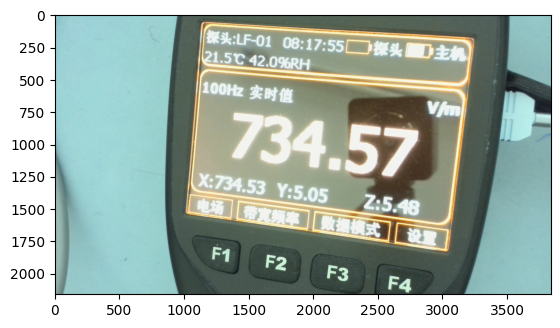

In [9]:
# Download images
IMG_URL = "https://user-images.githubusercontent.com/83450930/236680146-5751e291-d509-4d71-a2cb-bfbf35609051.jpg"
IMG_FILE_NAME = IMG_URL.split("/")[-1]
utils.download_file(IMG_URL, show_progress=False)

# Read image
img = cv2.imread(IMG_FILE_NAME)

# Show input image
plt.imshow(img)

### Preprocessing the input image

Cut the screen part and use affine transformations to normalize skewed images

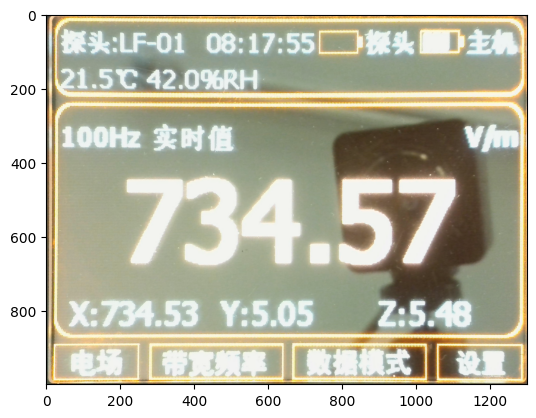

In [10]:
# affine transformations to normalize skewed images
img = pre_processing(img, POINTS, DESIGN_SHAPE)

# The screen part is cut and corrected
plt.imshow(img)

### Cut the element fields and recognition

In [11]:
# copy the structure output template
struct_result = copy.deepcopy(DESIGN_LAYOUT)

# structure recognition begins here
for key in DESIGN_LAYOUT.keys():
    # cut imgs according the layout information
    xmin, ymin, xmax, ymax = DESIGN_LAYOUT[key]
    cut_img = img[ymin:ymax, xmin:xmax]
    
    h = ymax - ymin  # height of cut_img
    w = xmax - xmin  # width of cut_img
    dt_boxes = [np.array([[0,0],[w,0],[w,h],[0,h]],dtype='float32')]
    batch_num = 1
    
    # since the input img is cut, we do not need a detection model to find the position of texts
    # Preprocess detection results for recognition.
    img_crop_list, img_num, indices = prep_for_rec(dt_boxes, cut_img)

    # For storing recognition results, include two parts:
    # txts are the recognized text results, scores are the recognition confidence level. 
    rec_res = [['', 0.0]] * img_num
    txts = [] 
    scores = []

    for beg_img_no in range(0, img_num):

        # Recognition starts from here.
        norm_img_batch = batch_text_box(
            img_crop_list, img_num, indices, beg_img_no, batch_num)

        # Run inference for text recognition. 
        rec_results = rec_compiled_model([norm_img_batch])[rec_output_layer]

        # Postprocessing recognition results.
        rec_result = text_decoder(rec_results)
        for rno in range(len(rec_result)):
            rec_res[indices[beg_img_no + rno]] = rec_result[rno]   
        if rec_res:
            txts = [rec_res[i][0] for i in range(len(rec_res))] 
            scores = [rec_res[i][1] for i in range(len(rec_res))]
    
    # record the recognition result
    struct_result[key] = txts[0]

# the raw output information
print(struct_result)

{'Info_Probe': '换头：LF-01', 'Freq_Set': '100H2实时值', 'Val_Total': '734.57', 'Val_X': 'X:734.53', 'Val_Y': 'Y:5.05', 'Val_Z': 'Z:5.48', 'Unit': 'vm', 'Field': '电场'}


### Postprocessing the output information

Fix the errors made in recognition.

In [12]:
# Post-processing, fix some error made in recognition
post_processing(struct_result)

# Print result
print(struct_result)

{'Info_Probe': '探头:LF-01', 'Freq_Set': '100Hz', 'Val_Total': '734.57', 'Val_X': '734.53', 'Val_Y': '5.05', 'Val_Z': '5.48', 'Unit': 'V/m', 'Field': '电场'}


 ## Try it with your meter photos!
 
 For your own photos, you only need to modify the `Configuration` and `post_processing` to run above!